In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import seaborn as sns

In [2]:
df = pd.read_csv("Indicators.csv")

# Dados básicos sobre o dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5656458 entries, 0 to 5656457
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   CountryName    object 
 1   CountryCode    object 
 2   IndicatorName  object 
 3   IndicatorCode  object 
 4   Year           int64  
 5   Value          float64
dtypes: float64(1), int64(1), object(4)
memory usage: 258.9+ MB


In [4]:
df

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06
...,...,...,...,...,...,...
5656453,Zimbabwe,ZWE,Time required to register property (days),IC.PRP.DURS,2015,3.600000e+01
5656454,Zimbabwe,ZWE,Time required to start a business (days),IC.REG.DURS,2015,9.000000e+01
5656455,Zimbabwe,ZWE,Time to prepare and pay taxes (hours),IC.TAX.DURS,2015,2.420000e+02
5656456,Zimbabwe,ZWE,Time to resolve insolvency (years),IC.ISV.DURS,2015,3.300000e+00


In [5]:
for c in df.columns:
    print(f"`{c}`:", df[c].nunique(), "valores únicos")

`CountryName`: 247 valores únicos
`CountryCode`: 247 valores únicos
`IndicatorName`: 1344 valores únicos
`IndicatorCode`: 1344 valores únicos
`Year`: 56 valores únicos
`Value`: 3601477 valores únicos


# Selecionando os indicadores

Usei essa estratégia para buscar indicadores que tenham uma correlação interessante, mas que não seja perfeita (1 ou -1).

Os pares de indicadores podem parecer aleatórios entre si, mas alguma relação entre eles tem de haver.

Também pode ser que um seja dependente do outro e não saibamos a razão disso.

Não necessariamente um implica no outro, mas o fato de ambos serem correlatos pode indicar que existe um outro fator que influencie em ambos.

Por exemplo, o alto investimento em esporte pode, ao mesmo tempo, influenciar em mais medalhas olímpicas e na redução de obesidade infantil em determinado país. Estas duas últimas variáveis terão uma correlação alta, mas a razão disso é que ambas têm uma mesma raiz.

In [6]:
# Países selecionadas
countries_of_interest = ["Brazil", "Argentina", "France", "Germany", "China", "Japan", "United States", "Canada"]

common_indicators = None

for country in countries_of_interest:
    country_indicators = set(df[df['CountryName'] == country]['IndicatorName'].unique())

    if common_indicators is None:
        common_indicators = country_indicators
    else:
        common_indicators = common_indicators.intersection(country_indicators)

common_indicators = list(common_indicators)

df = df[df['IndicatorName'].isin(common_indicators)]

correlations = pd.DataFrame()

for year in df['Year'].unique():
    df_year = df[df['Year'] == year]

    df_avg = df_year.groupby(['CountryName', 'IndicatorName'])['Value'].mean().reset_index()

    df_pivot = df_avg.pivot(index='CountryName', columns='IndicatorName', values='Value')

    corr_matrix = df_pivot.corr()

    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    corr_matrix = corr_matrix.where(mask)

    corr_unstacked = corr_matrix.unstack().rename_axis(["Indicator1", "Indicator2"]).reset_index(name='Correlation')

    corr_unstacked['Year'] = year

    correlations = pd.concat([correlations, corr_unstacked])

correlations = correlations[correlations['Correlation'].notnull()]

correlations = correlations[~np.isclose(correlations['Correlation'], 1.0, atol=1e-10)]
correlations = correlations[~np.isclose(correlations['Correlation'], -1.0, atol=1e-10)]

correlations['AbsCorrelation'] = correlations['Correlation'].abs()

# correlações entre 0.65 - 0.85 e após o ano 2000
correlations = correlations[(correlations['AbsCorrelation'] >= 0.65) & (correlations['AbsCorrelation'] <= 0.85) & (correlations['Year'] > 2000)]

top_correlations = correlations.sample(10).sort_values(by='AbsCorrelation', ascending=False)

top_correlations

,Indicator1,Indicator2,Correlation,Year,AbsCorrelation
294586,"Taxes on income, profits and capital gains (% ...",Merchandise imports (current US$),0.849513,2013,0.849513
198305,"International tourism, expenditures for passen...",Forest area (sq. km),0.827293,2012,0.827293
321261,Scientific and technical journal articles,Industrial nitrous oxide emissions (thousand m...,0.824999,2008,0.824999
359938,"Teachers in secondary education, female (number)","Patent applications, nonresidents",0.791617,2005,0.791617
329730,"Teachers in secondary education, both sexes (n...","Goods exports (BoP, current US$)",0.760523,2006,0.760523
341626,Transport services (% of commercial service im...,"Communications, computer, etc. (% of service i...",0.758238,2011,0.758238
213906,"Life expectancy at birth, female (years)",Combustible renewables and waste (% of total e...,-0.729166,2012,0.729166
123753,"Final consumption expenditure, etc. (constant ...",Agricultural land (sq. km),0.710931,2010,0.710931
229891,Land under cereal production (hectares),Adjusted net national income (current US$),0.686830,2005,0.686830
132560,GDP per capita (current LCU),Discrepancy in expenditure estimate of GDP (co...,0.680261,2008,0.680261


# Comparando os indicadores entre os países
Usei o FacetGrid do Seaborn para plotar as comparações entre os países em uma única imagem para cada indicador

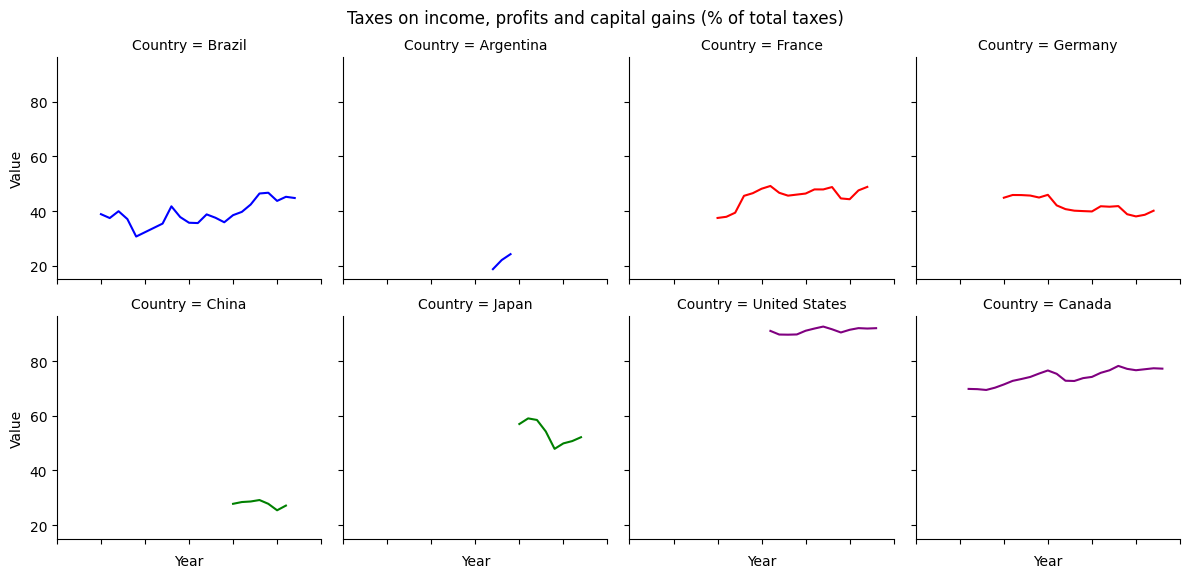

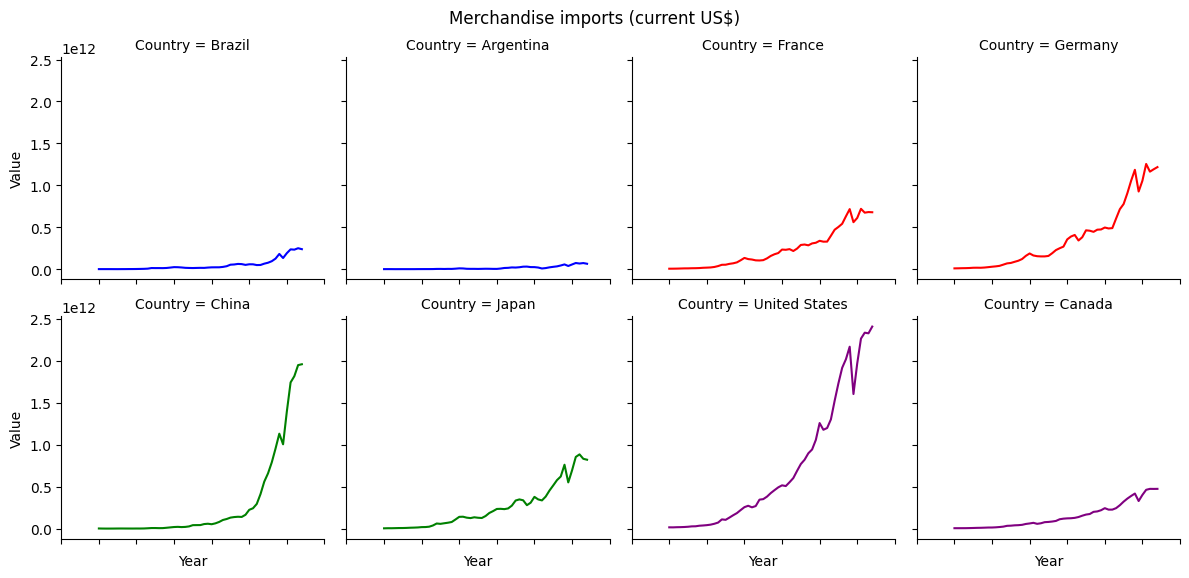

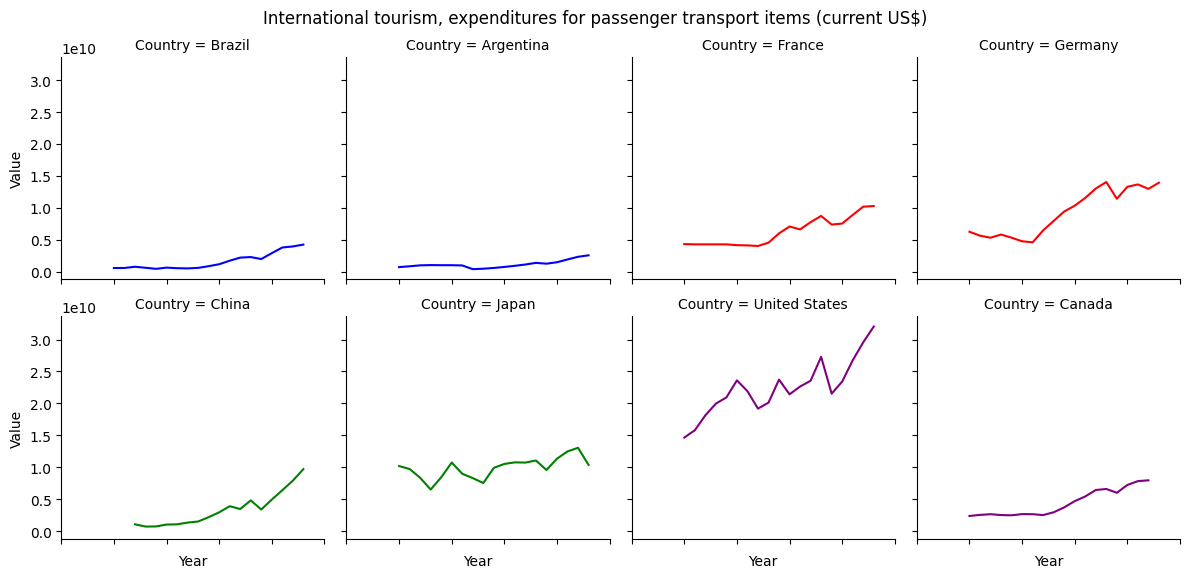

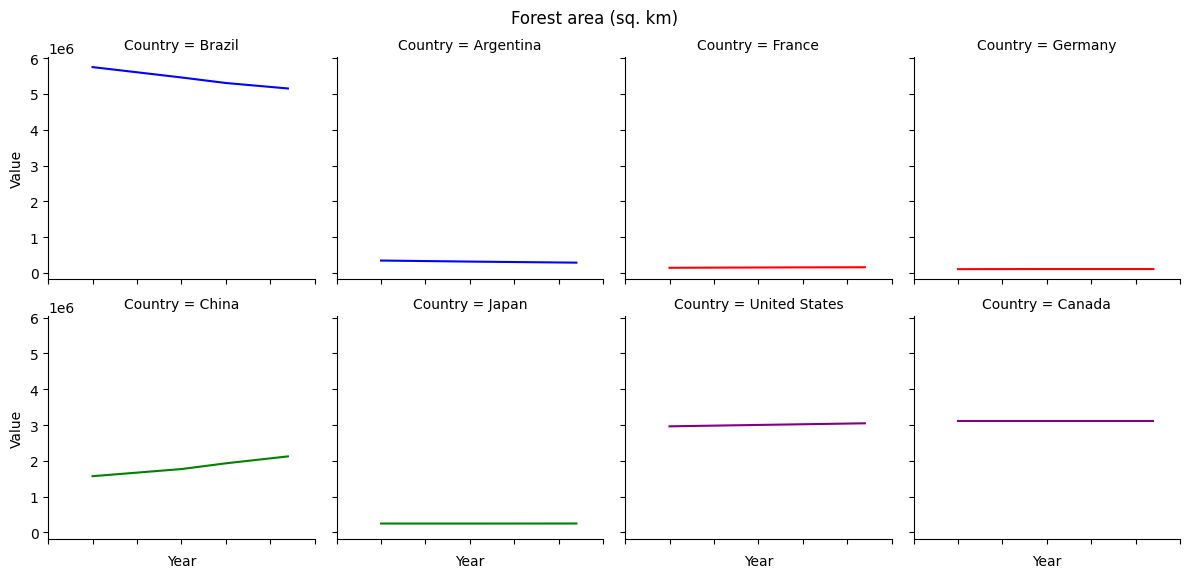

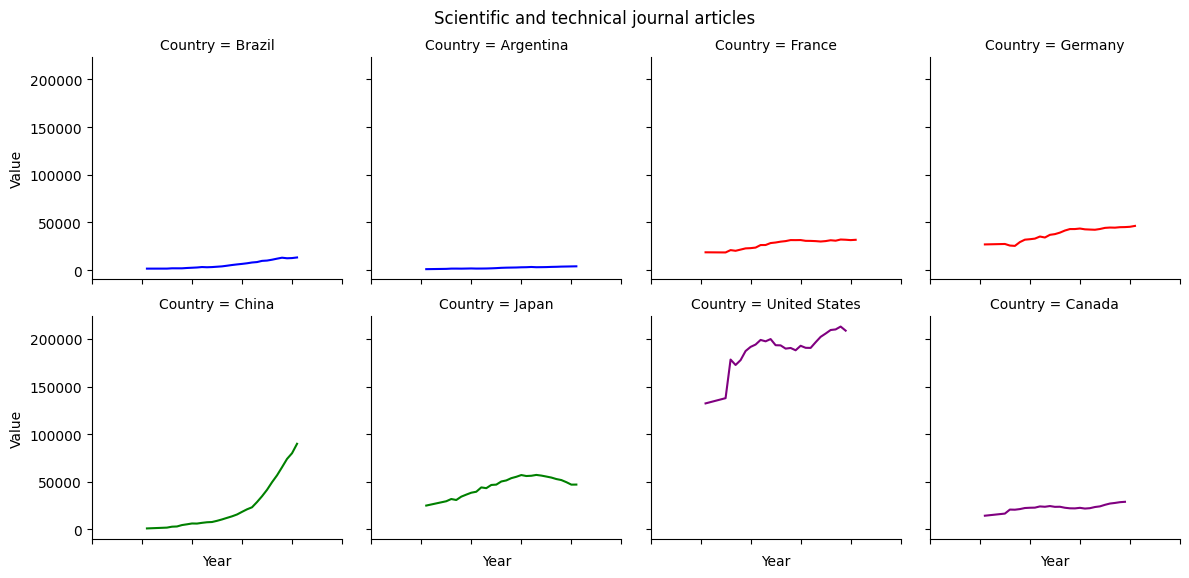

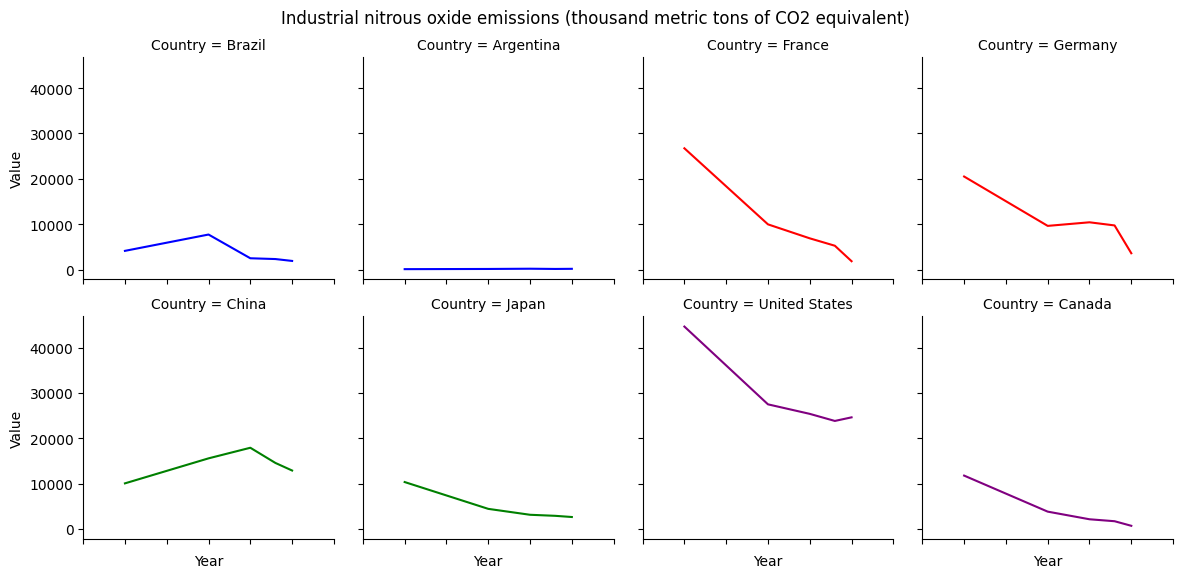

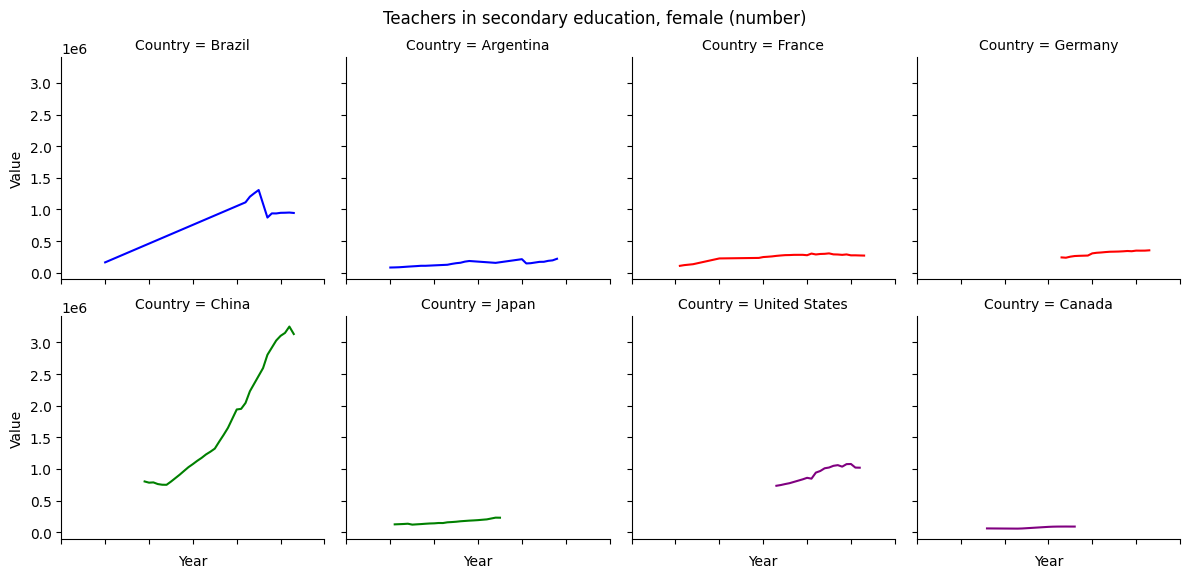

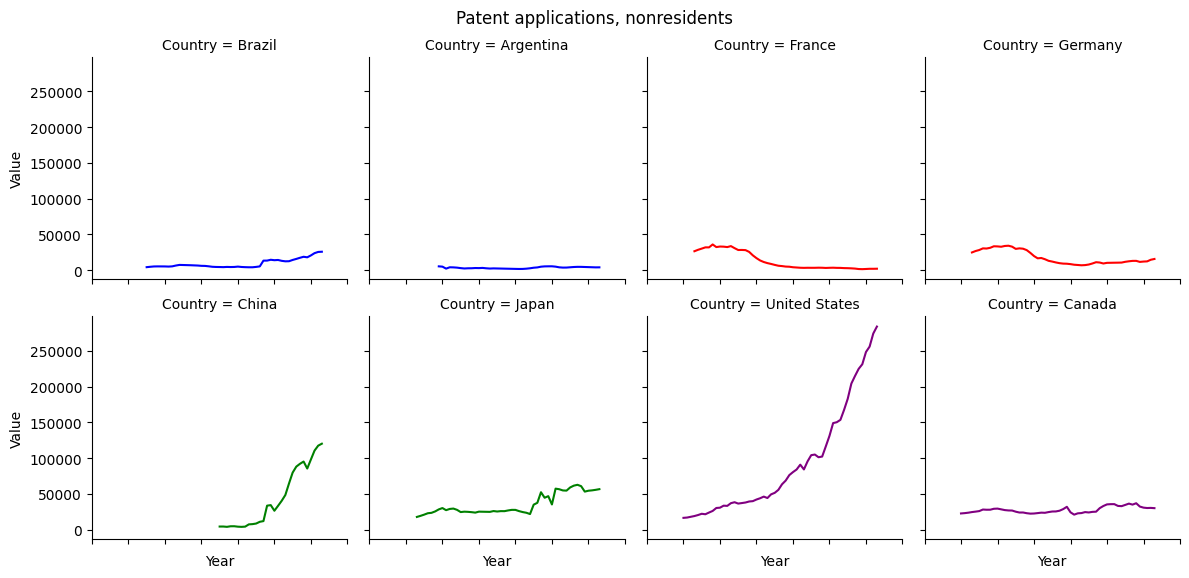

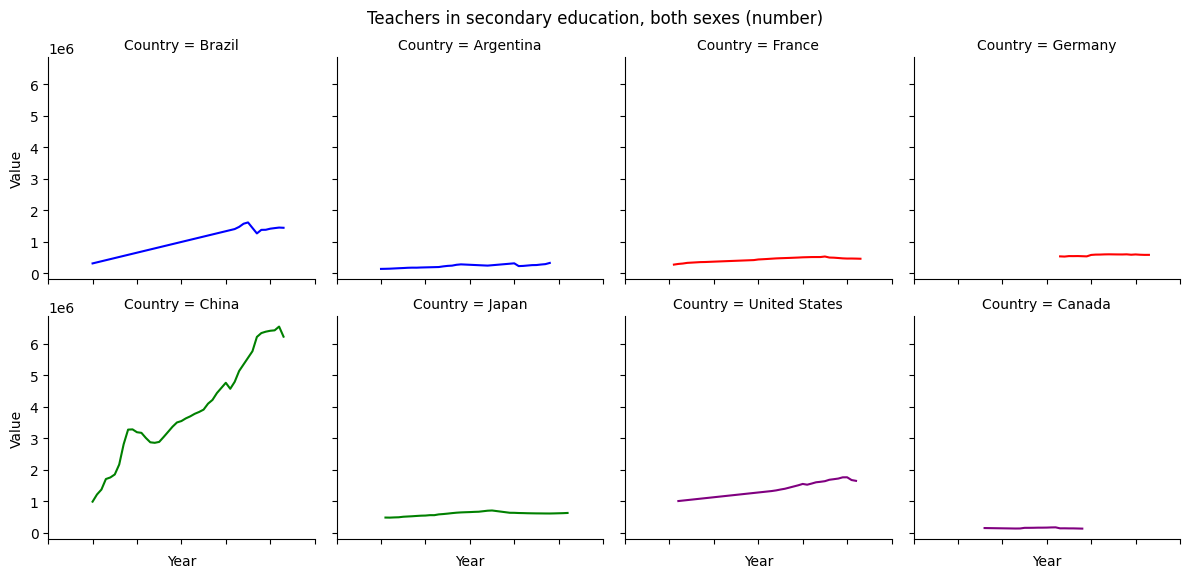

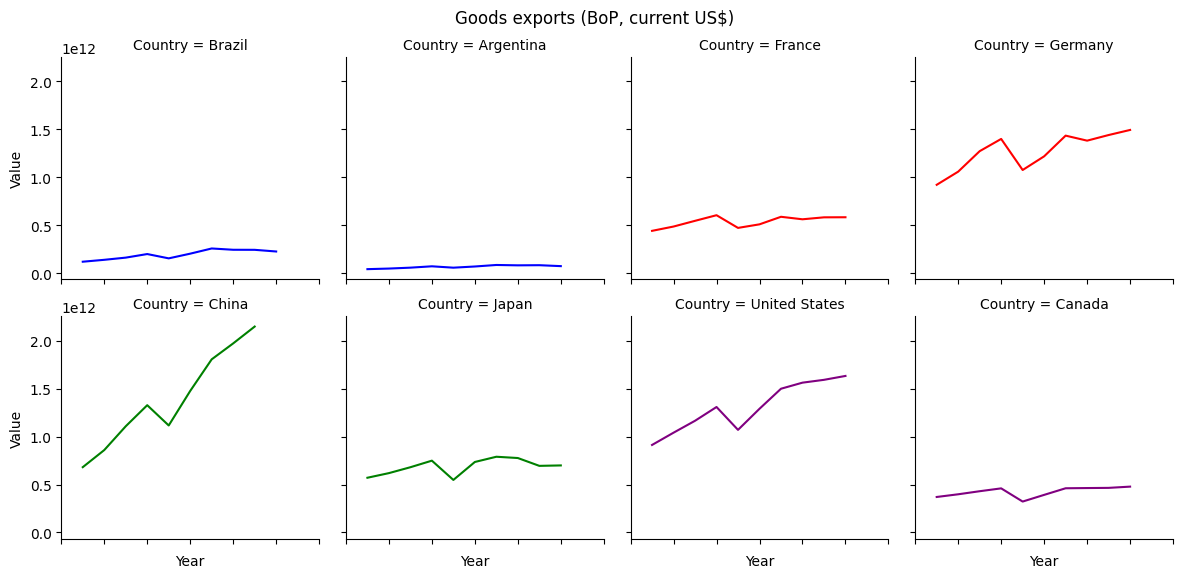

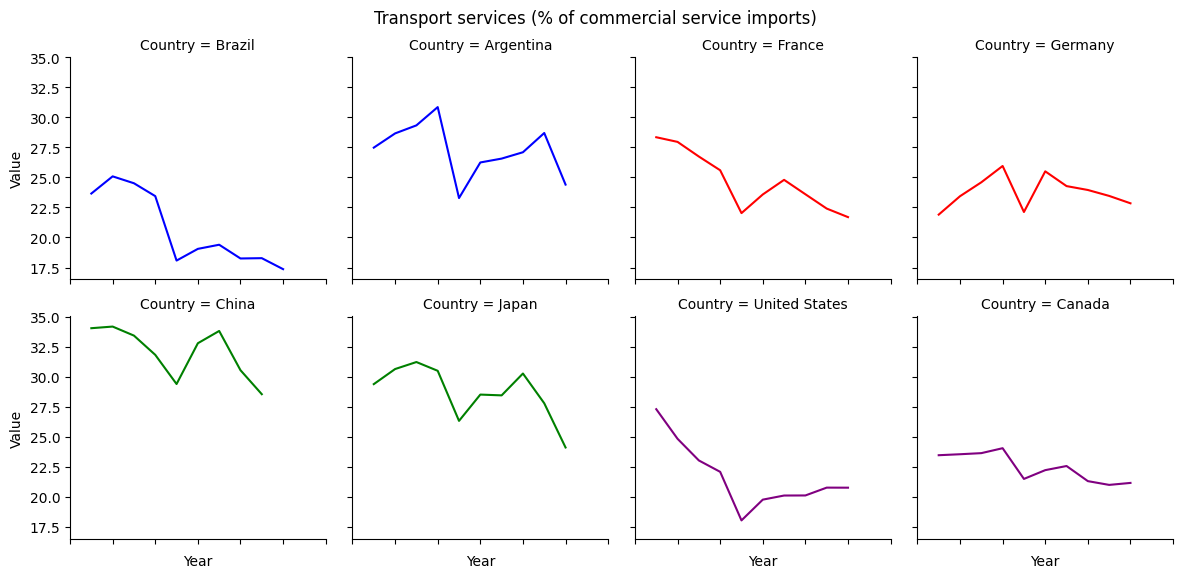

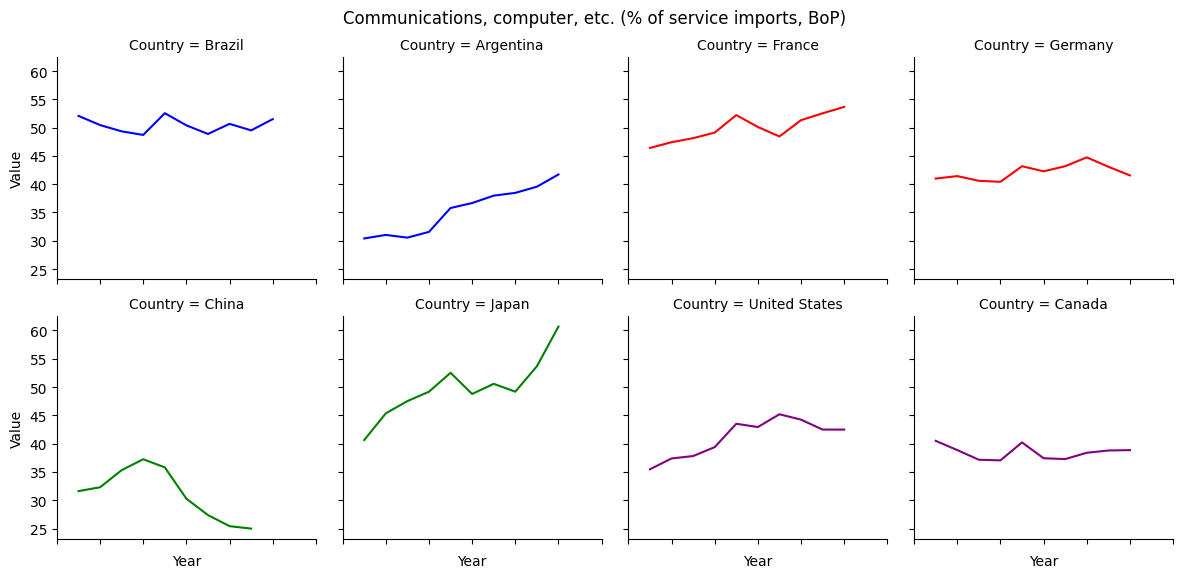

In [ ]:
colors = {'Brazil': 'blue', 'Argentina': 'blue', 'France': 'red', 'Germany': 'red', 
          'China': 'green', 'Japan': 'green', 'United States': 'purple', 'Canada': 'purple'}

region_list = colors.keys()

for _, row in top_correlations.iterrows():
    indicator1 = row['Indicator1']
    indicator2 = row['Indicator2']

    data1 = pd.DataFrame()
    data2 = pd.DataFrame()

    for country in region_list:
        country_indicator1 = df[(df['CountryName'] == country) & (df['IndicatorName'] == indicator1)].copy()
        country_indicator2 = df[(df['CountryName'] == country) & (df['IndicatorName'] == indicator2)].copy()

        country_indicator1['Country'] = country
        country_indicator2['Country'] = country

        data1 = pd.concat([data1, country_indicator1])
        data2 = pd.concat([data2, country_indicator2])

    g1 = sns.FacetGrid(data1, col='Country', col_wrap=4, height=3, hue='Country', palette=colors)
    g1.map(sns.lineplot, 'Year', 'Value')
    g1.set_xticklabels(rotation=90)
    plt.subplots_adjust(top=0.9)
    g1.fig.suptitle(indicator1)
    plt.show()

    g2 = sns.FacetGrid(data2, col='Country', col_wrap=4, height=3, hue='Country', palette=colors)
    g2.map(sns.lineplot, 'Year', 'Value')
    g2.set_xticklabels(rotation=90)
    plt.subplots_adjust(top=0.9)
    g2.fig.suptitle(indicator2)
    plt.show()
